In [4]:

import os
import sys
import networkx as nx
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString,Point
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import taxi_driver.taxi_driver as td

import plotly.express as px
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
#setting some much needed paths 

dataPath = os.path.join("..","data")
csvPath  = os.path.join(dataPath,"CSV")
shpPath  = os.path.join(dataPath,"SHP")

outputPath = os.path.join("..","outputs")
imagePath = os.path.join(outputPath,"images")



In [7]:
zoneShpPath = os.path.join(shpPath,"taxi_zones.shp")

#combine in one
march_path = os.path.join(dataPath,"yellow_tripdata_2024-03.parquet")
june_path = os.path.join(dataPath,"yellow_tripdata_2024-06.parquet")
nov_path = os.path.join(dataPath,"yellow_tripdata_2024-11.parquet")

taxi_df=td.Taxidf([march_path,june_path,nov_path],sample_fraction=0.2,taxi_zones_shp_path=zoneShpPath)
taxi_df.convert_dates()


/media/itoumpalidis/SlowHDD/linux_part/t2l/nyc_taxi_tips/srs/taxi_driver/taxi_driver.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.taxi_data=pd.concat([self.taxi_data,temp_df])


In [8]:
#remove unwanted months
taxi_df.taxi_data=taxi_df.taxi_data.loc[taxi_df.taxi_data['pu_month'].isin([3,6,11])]



### Temporal distribution

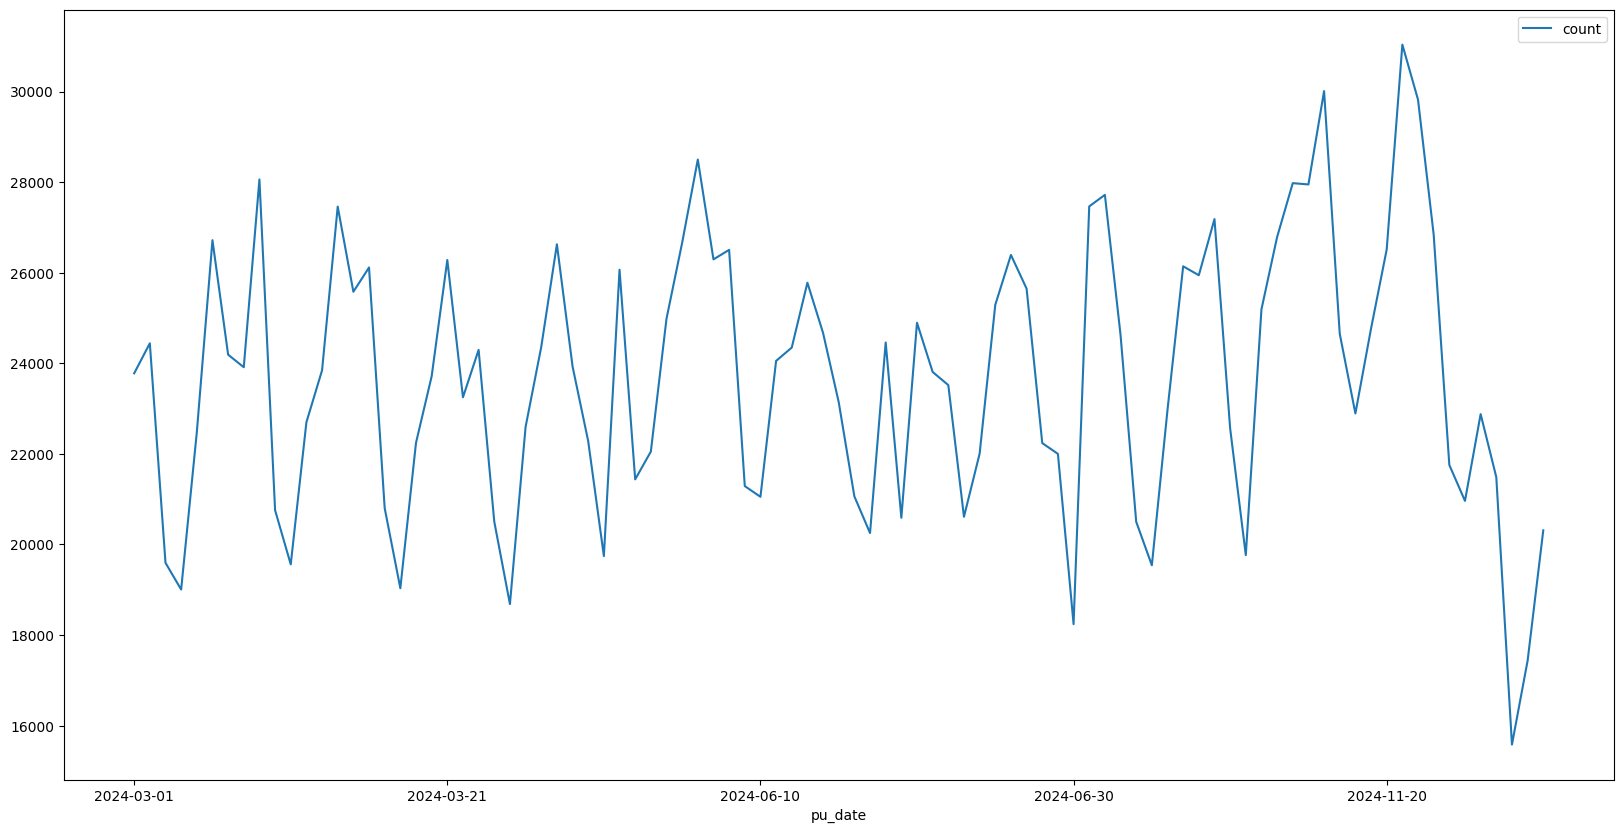

In [11]:
fig,ax = plt.subplots(figsize=(20,10))

taxi_df.grouped_date().plot(ax=ax)

fileName = os.path.join(imagePath,"entire_ts_monthly")
plt.savefig(fileName)



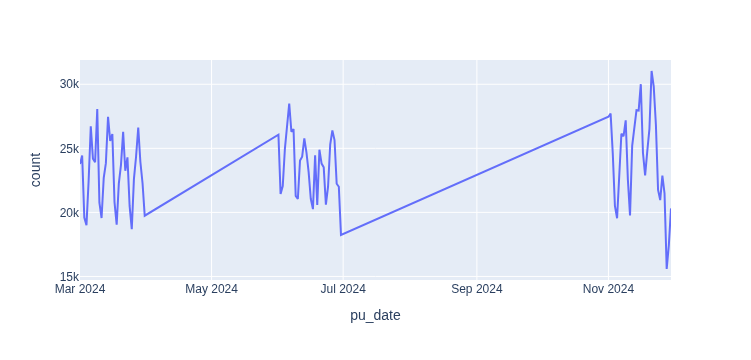

In [12]:

fig = px.line(taxi_df.grouped_date(), y="count")
fig.show()

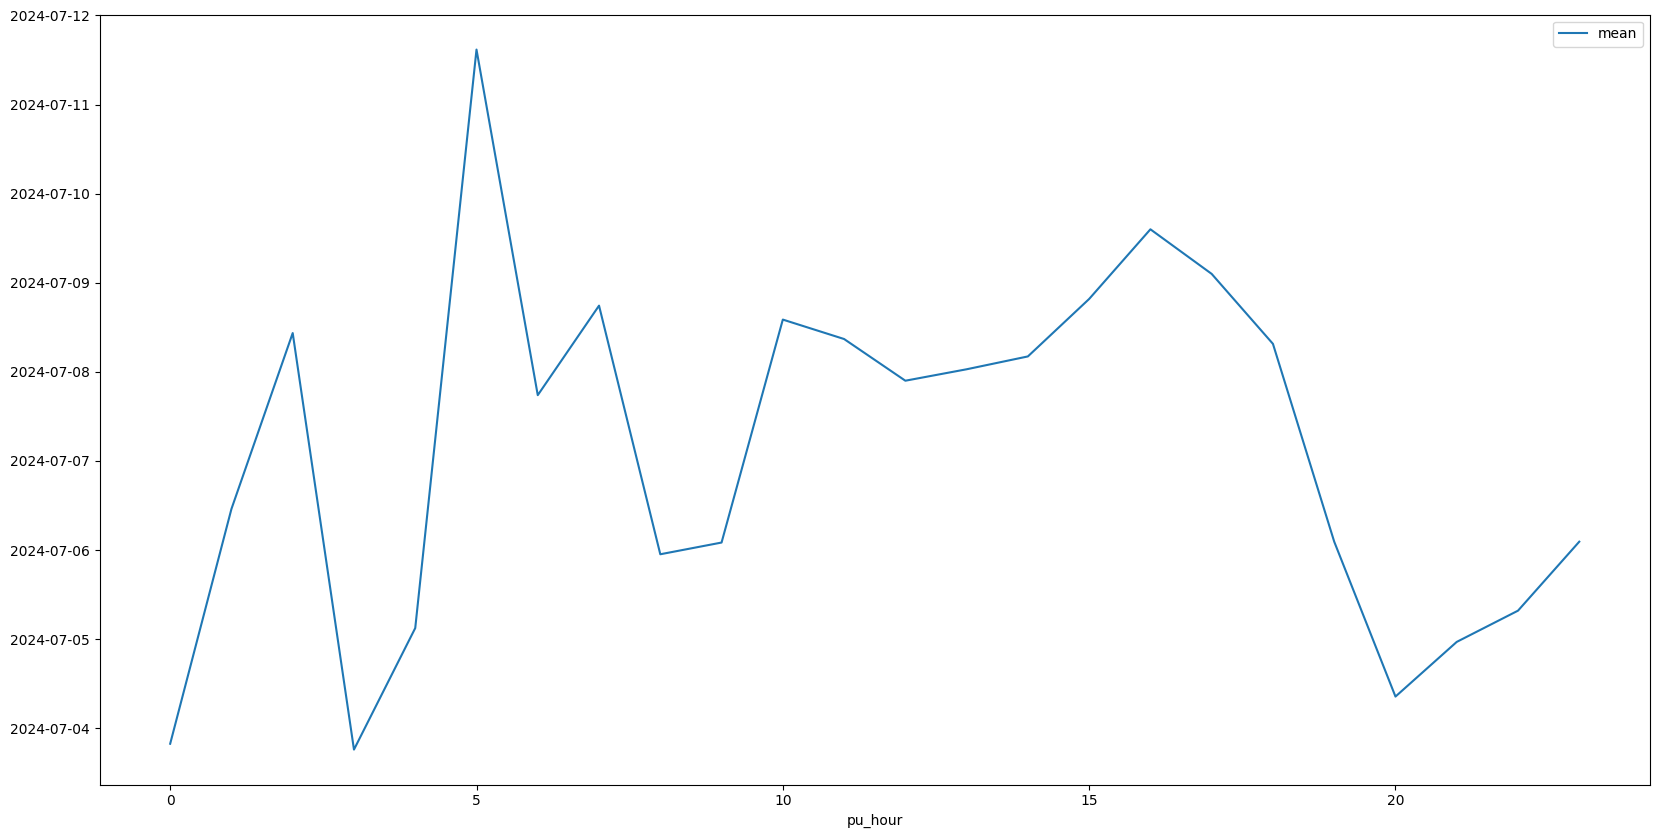

In [19]:
fig,ax = plt.subplots(figsize=(20,10))

# taxi_df.grouped_hour().plot(ax=ax)
taxi_df.grouped_hour(column='tip_amount',agg_functions=['mean']).plot(ax=ax)
fileName = os.path.join(imagePath,"sample_ts_hourly.png")
plt.savefig(fileName)

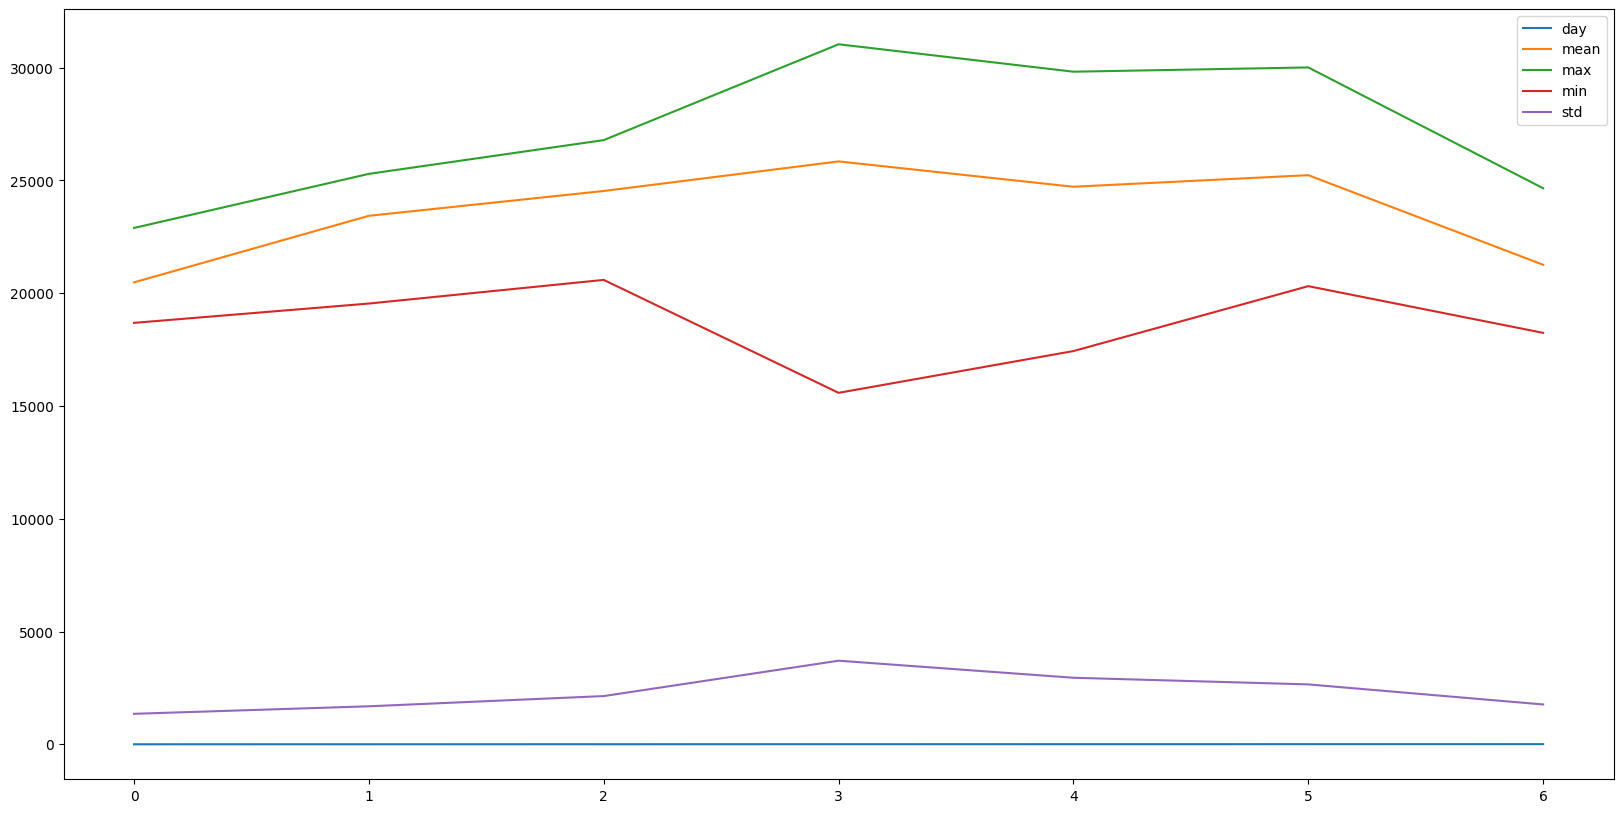

In [14]:
fig,ax = plt.subplots(figsize=(20,10))

taxi_df.count_grouped_weekday().plot(ax=ax)

fileName = os.path.join(imagePath,"sample_ts_weekday")
plt.savefig(fileName)

### Spatial Distribution

In [7]:
taxi_df.compute_taxi_zones()

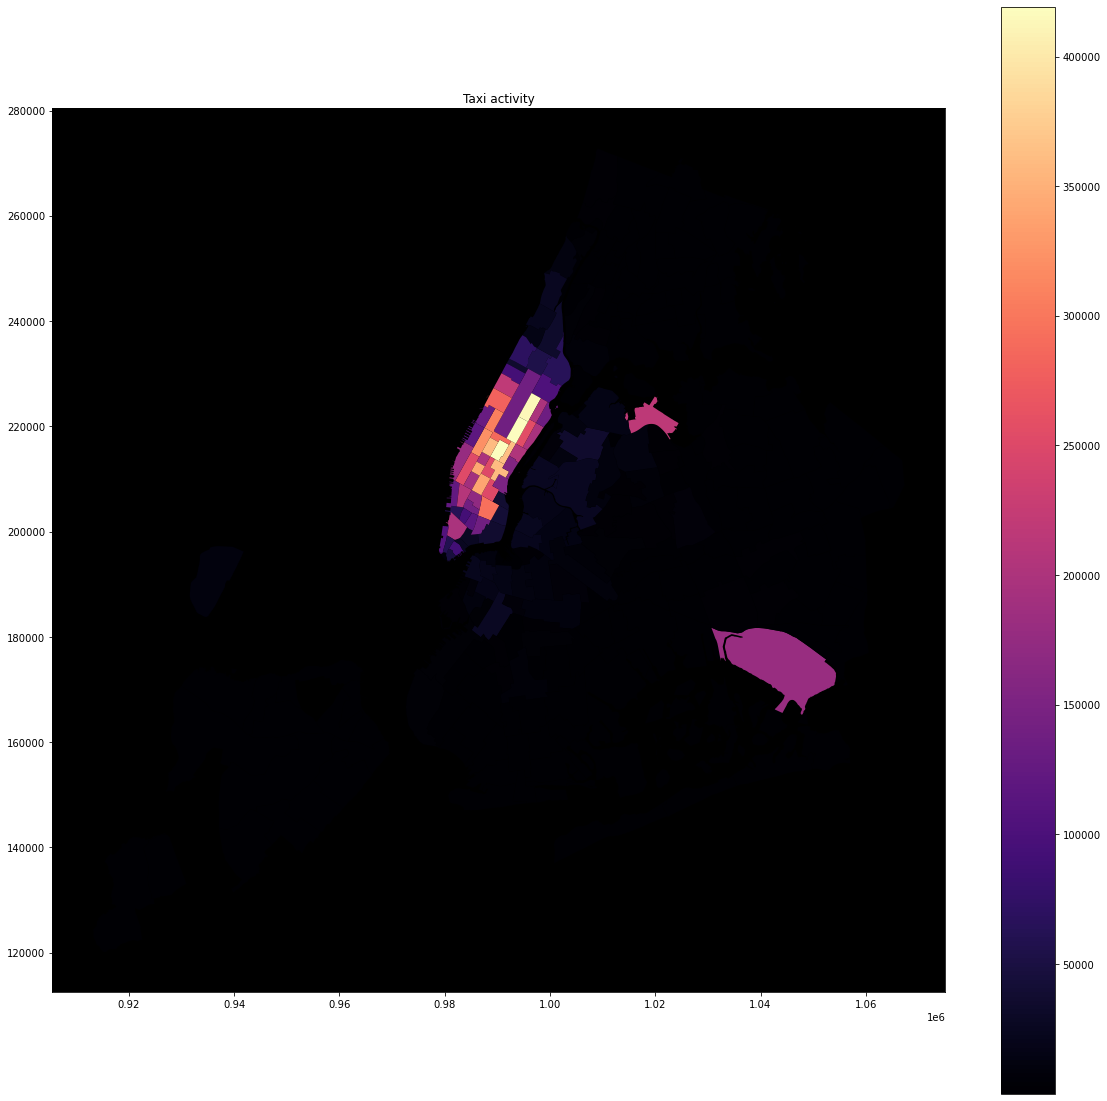

In [8]:
fig,ax = plt.subplots(figsize=(20,20))
ax.set_aspect("equal")
ax.set_facecolor("black")
taxi_df.taxi_zones.plot(column='taxi_activity', cmap='magma',ax=ax,legend=True)
ax.set_title("Taxi activity")

filePath = os.path.join(outputPath,"images","sample_spatial_count")
plt.savefig(filePath)

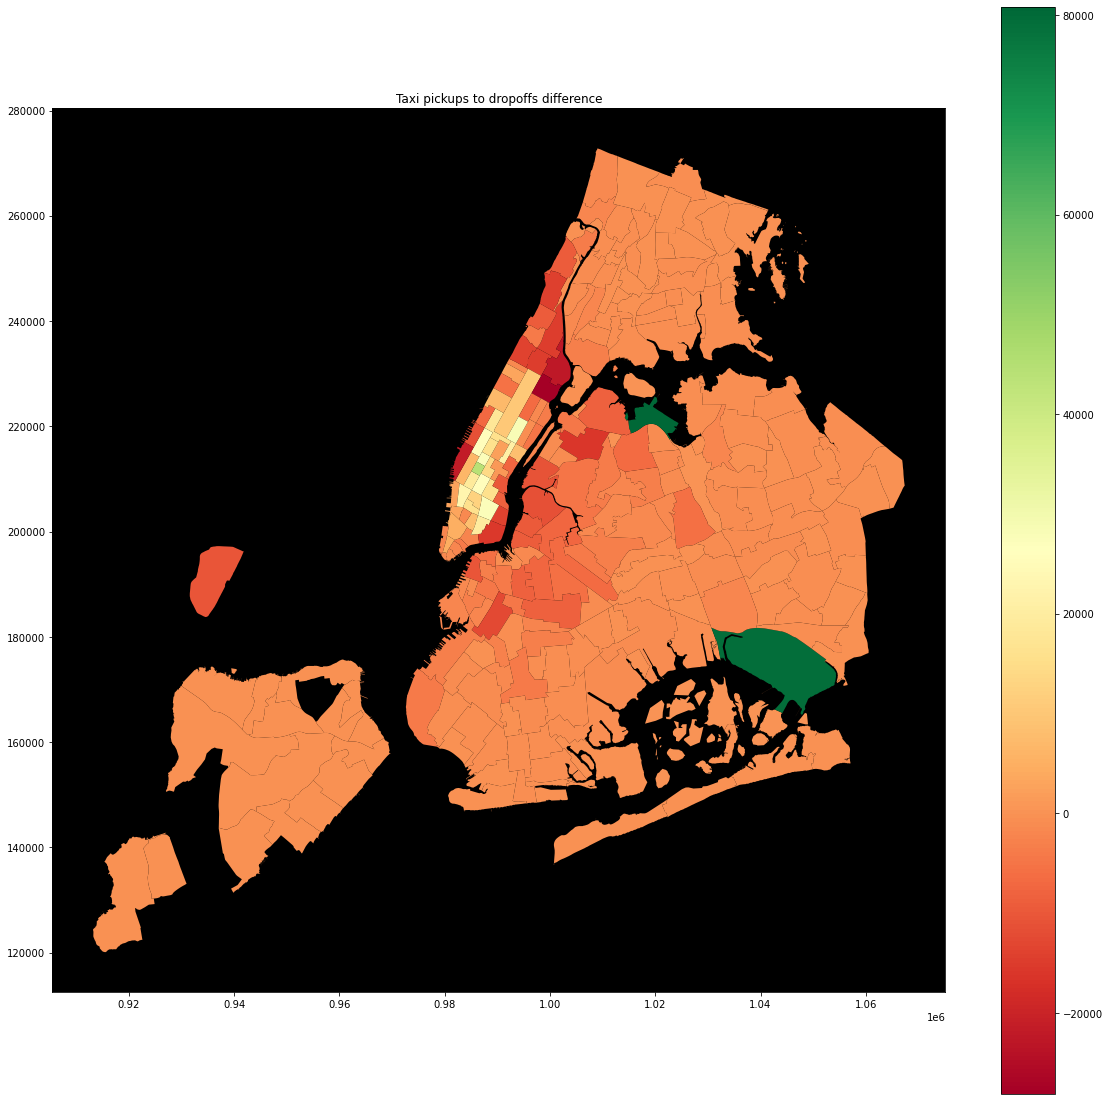

In [9]:
fig,ax = plt.subplots(figsize=(20,20))
ax.set_aspect("equal")
ax.set_facecolor("black")
taxi_df.taxi_zones.plot(column='taxi_demand', cmap='RdYlGn',ax=ax,legend=True)
ax.set_title("Taxi pickups to dropoffs difference")

filePath = os.path.join(outputPath,"images","sample_demand")
plt.savefig(filePath)

In [10]:
import plotly.express as px


fig = px.scatter(taxi_df.taxi_zones, x="PULocationID", y="DOLocationID", text="zone",color="taxi_demand_class")

fig.add_shape(
        # Line Diagonal
            type="line",
            x0=0,
            y0=0,
            x1=600000,
            y1=600000,
            line=dict(
                color="MediumPurple",
                width=4,
                dash="dot",
            )
)



fig.update_traces(textposition='top center')

fig.update_layout(
    height=800,
    title_text='Taxi pickups to drop-offs'
)

fig.show()

### Feature Analysis

In [11]:
taxi_df.taxi_data.describe().astype(int)

,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,Unnamed: 0,pu_month,do_month
count,5591791,5591791,5591791,5591791,5591791,5591791,5591791,5591791,5591791,5591791,5591791
mean,2,13,0,0,1,0,0,16,4768358,6,6
std,3,266,0,0,2,1,0,267,2838368,3,3
min,0,-550,-42,0,-11,-15,0,-550,2,3,3
25%,0,6,0,0,0,0,0,8,2327135,3,3
50%,1,9,0,0,1,0,0,11,4658592,6,6
75%,3,15,0,0,2,0,0,17,7023474,11,11
max,733,630461,69,103,450,990,1,630463,10294622,11,12


Need to clear some values, negative fare, trip distance and tip_amount.. 

In [86]:
#cleaning
clean_df=taxi_df.taxi_data.loc[(taxi_df.taxi_data['fare_amount']>0) & (taxi_df.taxi_data['fare_amount']<2000)]
clean_df=clean_df[clean_df['trip_distance']>0]
clean_df=clean_df[clean_df['tip_amount']>0]


In [87]:
clean_df['dollar_per_mile']=clean_df['fare_amount']/clean_df['trip_distance']
clean_df['tip_to_fare']=clean_df['tip_amount']/clean_df['fare_amount']
clean_df['duration_s']=(clean_df['tpep_dropoff_datetime']-clean_df['tpep_pickup_datetime']).apply(lambda x:x.seconds)

In [110]:
clean_df['duration_s'].describe().astype(int)

count    3644279
mean        1015
std         2953
min            0
25%          432
50%          714
75%         1162
max        86394
Name: duration_s, dtype: int64

In [111]:
#some weired values also exist here
clean_df['dollar_per_mile'].describe().astype(int)

count    3644279
mean           6
std           43
min            0
25%            4
50%            5
75%            7
max        15000
Name: dollar_per_mile, dtype: int64

It might help to look on the origin destinations on the map

In [1]:
sample_df=clean_df[clean_df['dollar_per_mile']>7]
od_data=sample_df[(sample_df['trip_distance']<1)].groupby(['PULocationID',"DOLocationID"])[['fare_amount',"trip_distance","duration_s"]].agg(['mean', 'min', 'max',"count","std"])
od_data.reset_index().sort_values(("fare_amount","mean"),ascending=False)


NameError: name 'clean_df' is not defined

In [157]:

taxi_df.graph_representation()
taxi_df.assign_attributes_to_graph(od_data,[("fare_amount","count"),("fare_amount","mean"),("trip_distance","mean"),("duration_s","mean")])



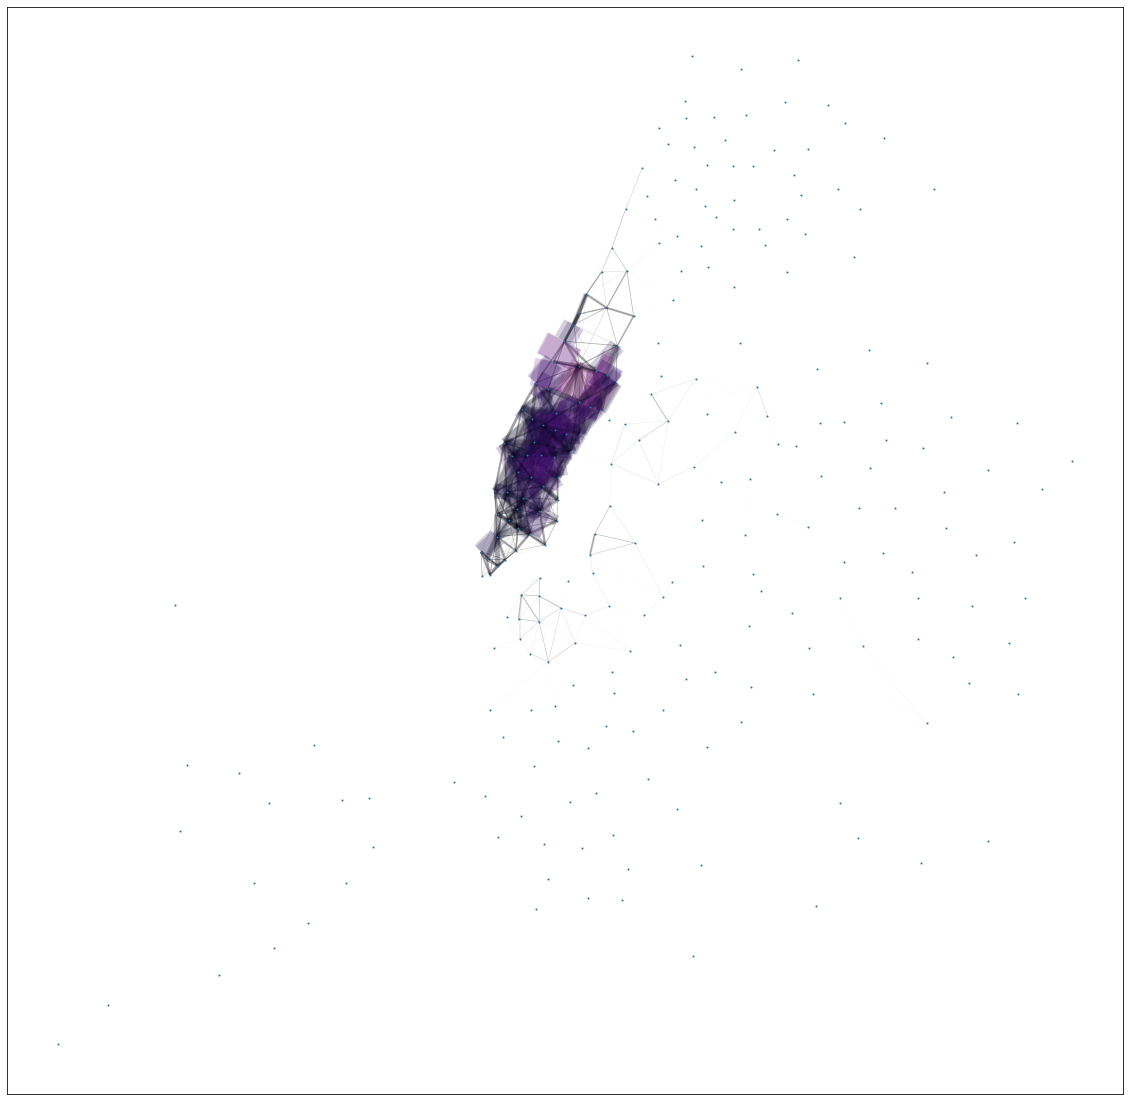

In [158]:
#most of the trips sampled with higher than 7dollar per mile existin in the manhattan area

min_vals=np.array(list(nx.get_edge_attributes(taxi_df.G_main,("fare_amount","count")).values()))
cmap=plt.get_cmap("magma")

colors = [cmap(i)for i in (np.array(min_vals)/max(min_vals))]

        
fig,ax = plt.subplots(figsize=(20,20))
nx.draw_networkx_nodes(taxi_df.G_main,pos=taxi_df.pos,node_size=1,ax=ax)
nx.draw_networkx_edges(taxi_df.G_main,pos=taxi_df.pos,arrows=False,ax=ax,width=min_vals*0.01,alpha=0.2,
                       edge_color=colors,edge_cmap=plt.get_cmap("magma"))

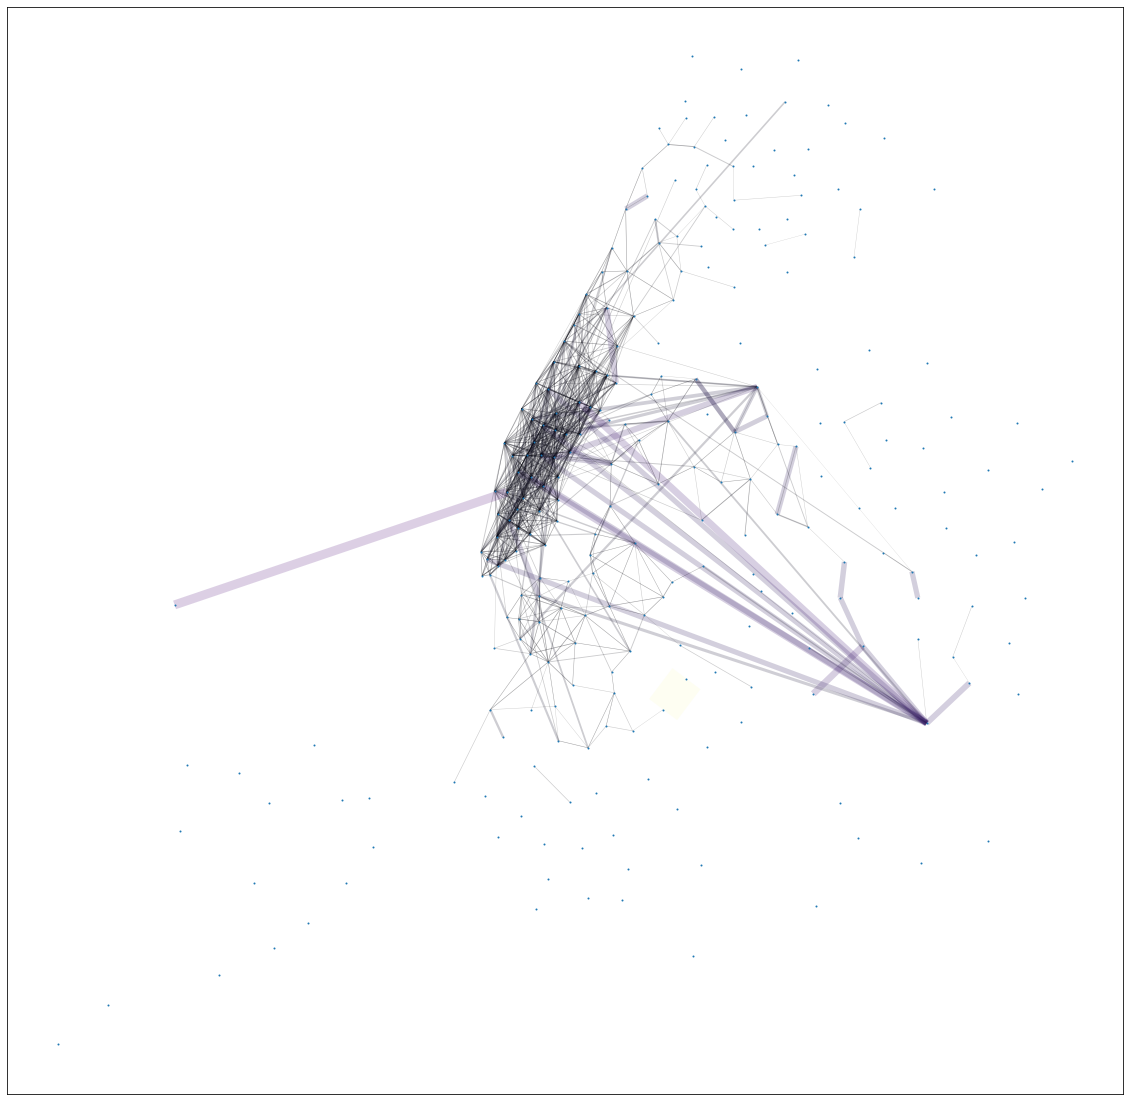

In [156]:
#visualizing though the fare amount mean we can see that this is 

min_vals=np.array(list(nx.get_edge_attributes(taxi_df.G_main,("fare_amount","mean")).values()))
cmap=plt.get_cmap("magma")

colors = [cmap(i)for i in (np.array(min_vals)/max(min_vals))]

# last_quantile_edges= []
# count_values =[]
# for edge_ in list(G.edges(data=True)):
#     if (edge_[2]['count']>1000) :
#         last_quantile_edges.append((edge_[0],edge_[1]))
#         count_values.append(edge_[2]['std'])
        
        
fig,ax = plt.subplots(figsize=(20,20))
nx.draw_networkx_nodes(taxi_df.G_main,pos=taxi_df.pos,node_size=1,ax=ax)
nx.draw_networkx_edges(taxi_df.G_main,pos=taxi_df.pos,arrows=False,ax=ax,width=min_vals*0.1,alpha=0.2,
                       edge_color=colors,edge_cmap=plt.get_cmap("magma"))

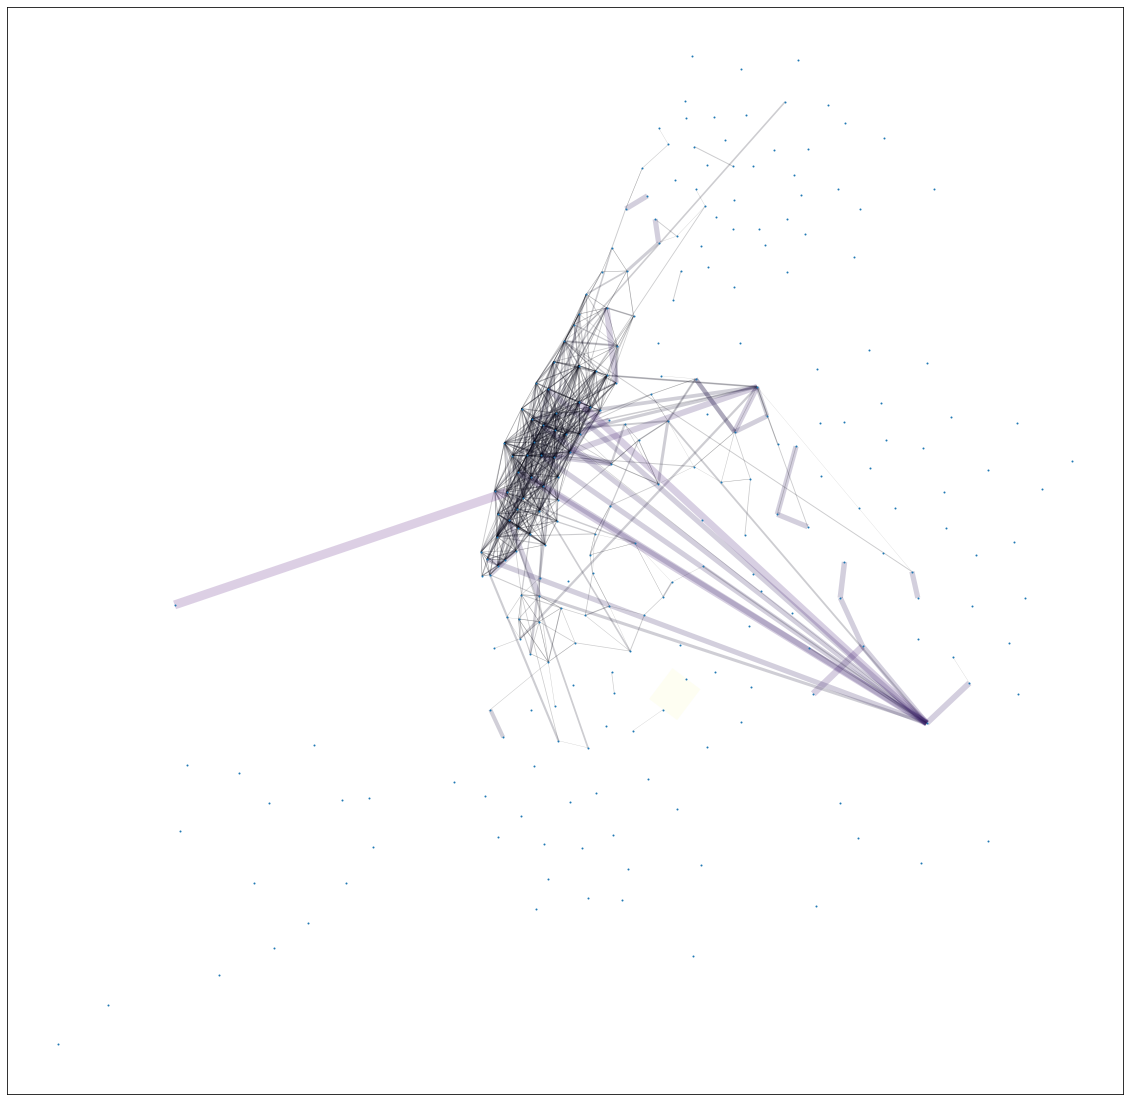

In [152]:
sample_df=clean_df[clean_df['dollar_per_mile']>10]


od_data=sample_df[(sample_df['trip_distance']<1)].groupby(['PULocationID',"DOLocationID"])[['fare_amount',"trip_distance","duration_s"]].agg(['mean', 'min', 'max',"count","std"])
od_data.reset_index().sort_values(("fare_amount","mean"),ascending=False)
taxi_df.graph_representation()
taxi_df.assign_attributes_to_graph(od_data,[("fare_amount","mean"),("trip_distance","mean"),("duration_s","mean")])

min_vals=np.array(list(nx.get_edge_attributes(taxi_df.G_main,("fare_amount","mean")).values()))
cmap=plt.get_cmap("magma")

colors = [cmap(i)for i in (np.array(min_vals)/max(min_vals))]

# last_quantile_edges= []
# count_values =[]
# for edge_ in list(G.edges(data=True)):
#     if (edge_[2]['count']>1000) :
#         last_quantile_edges.append((edge_[0],edge_[1]))
#         count_values.append(edge_[2]['std'])
        
        
fig,ax = plt.subplots(figsize=(20,20))
nx.draw_networkx_nodes(taxi_df.G_main,pos=taxi_df.pos,node_size=1,ax=ax)
nx.draw_networkx_edges(taxi_df.G_main,pos=taxi_df.pos,arrows=False,ax=ax,width=min_vals*0.1,alpha=0.2,
                       edge_color=colors,edge_cmap=plt.get_cmap("magma"))